# 🧪 Exploração e Análise Inicial — Breast Cancer Wisconsin (Diagnostic)

Notebook inicial para importar dados, utilitários de EDA e realizar análises exploratórias de base. Este caderno assume a estrutura de projeto com `src/` e dados em `data/wdbc.csv`.

## 🎯 Objetivos
- Garantir que o caminho do projeto esteja configurado para importar `src/`
- Carregar o dataset `data/wdbc.csv` (com *fallback* via `sklearn` se não existir)
- Executar checagens rápidas: dimensões, amostra, dtypes, **balanceamento da variável-alvo**
- Rodar resumos com `skim_numeric` e `skim_categorical` e salvar em `data/interim/eda/`
- Visualizações básicas com **matplotlib** (sem seaborn)

In [1]:
from pathlib import Path
import sys

def add_project_root(max_up=3, marker='src'):
    p = Path().resolve()
    for _ in range(max_up + 1):
        if (p / marker).exists():
            sys.path.insert(0, str(p))
            return p
        p = p.parent
    raise RuntimeError(f"Não encontrei a pasta '{marker}' nos níveis acima.")

ROOT = add_project_root()
print('Repo root:', ROOT)

Repo root: /home/carloslessa/FCD/POSTECH/modulo3/tech-challenge-3


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional
try:
    from src.eda.skim import skim_numeric, skim_categorical
    SKIM_OK = True
except Exception as e:
    SKIM_OK = False
    print('Aviso: não foi possível importar skim_numeric/skim_categorical. Erro:', e)
    print('Verifique se existem src/eda/skim.py e __init__.py nos diretórios src/ e src/eda/.')

In [3]:
# Importa a função diretamente
from src.data.make_wdbc_dataset import build_wdbc

# Define o caminho para o arquivo de dados
DATA_PATH = ROOT / "data" / "wdbc.csv"

# Garante que o diretório 'data' exista
DATA_PATH.parent.mkdir(parents=True, exist_ok=True)

# Verifica se o arquivo já existe
if not DATA_PATH.exists():
    print(f"Arquivo não encontrado em {DATA_PATH}. Gerando via função build_wdbc...")
    try:
        # Chama a função diretamente
        build_wdbc(DATA_PATH)
        print(f"Arquivo gerado e salvo em {DATA_PATH}")
    except Exception as e:
        print("Falha ao rodar o módulo CLI; gerando via sklearn. Erro:", e)
        from sklearn.datasets import load_breast_cancer
        cancer = load_breast_cancer()
        df_tmp = pd.DataFrame(
            cancer["data"],
            columns=[c.replace(" ", "_") for c in cancer["feature_names"]]
        )
        target = pd.Categorical.from_codes(cancer["target"], cancer["target_names"])
        target = target.rename_categories({"malignant": "Maligno", "benign": "Benigno"})
        df_tmp["diagnosis"] = target.astype(str)
        df_tmp.to_csv(DATA_PATH, index=False)
        print("Gerado e salvo em", DATA_PATH)

# Se chegou até aqui, o arquivo deve existir. Carrega o DataFrame.
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()

Shape: (569, 31)


,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,Maligno
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,Maligno
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,Maligno
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,Maligno
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,Maligno


## ⚖️ Balanceamento da variável-alvo (`diagnosis`)

diagnosis
Benigno    357
Maligno    212
Name: count, dtype: int64


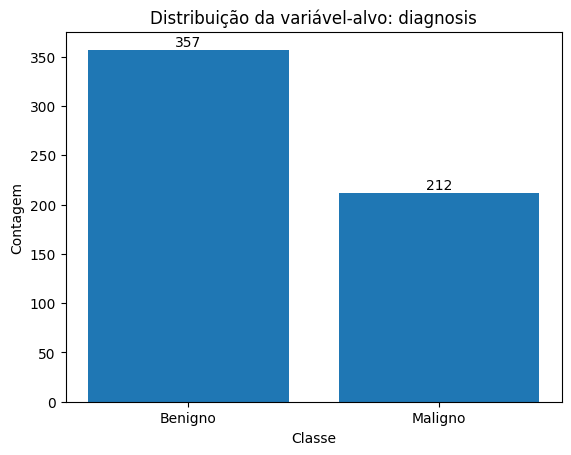

In [4]:
if 'diagnosis' in df.columns:
    vc = df['diagnosis'].value_counts(dropna=False)
    print(vc)
    fig = plt.figure()
    plt.bar(vc.index.astype(str), vc.values)
    plt.title('Distribuição da variável-alvo: diagnosis')
    plt.xlabel('Classe')
    plt.ylabel('Contagem')
    for i, v in enumerate(vc.values):
        plt.text(i, v, str(v), ha='center', va='bottom')
    plt.show()
else:
    print('Coluna diagnosis não encontrada.')

In [9]:
skim_cat = skim_categorical(df)
print(skim_cat.to_string(index=False))

 variable  miss  ordered  n_unique           top_counts
diagnosis     0    False         2 Beni: 357, Mali: 212


## 🔎 Resumo estatístico das variáveis numéricas

In [ ]:
skim_num = skim_numeric(df)
print(skim_num.to_string(index=False))

               variable  miss  p_zeros  unique    mean      sd    CV      p0     p25     p50      p75     p100     IQR  hist  skew   kurt
            mean_radius     0   0.0000     456  14.127   3.524 0.249   6.981  11.700  13.370   15.780   28.110   4.080 ▃█▃▂▁ 0.940  0.828
           mean_texture     0   0.0000     479  19.290   4.301 0.223   9.710  16.170  18.840   21.800   39.280   5.630 ▃█▄▁▁ 0.649  0.741
         mean_perimeter     0   0.0000     522  91.969  24.299 0.264  43.790  75.170  86.240  104.100  188.500  28.930 ▃█▃▁▁ 0.988  0.953
              mean_area     0   0.0000     539 654.889 351.914 0.537 143.500 420.300 551.100  782.700 2501.000 362.400 █▄▂▁▁ 1.641  3.610
        mean_smoothness     0   0.0000     474   0.096   0.014 0.146   0.053   0.086   0.096    0.105    0.163   0.019 ▁█▇▁▁ 0.455  0.838
       mean_compactness     0   0.0000     537   0.104   0.053 0.506   0.019   0.065   0.093    0.130    0.345   0.065 █▇▃▁▁ 1.187  1.625
         mean_concavity     0   0.

## 🔗 Correlações (numéricas)

In [ ]:

# Correlação de Spearman
df_corr = df.drop(columns=["diagnosis"])
corr = df_corr.corr(numeric_only=True, method="spearman").abs()

# Pegar só metade superior da matriz e listar top pares
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
top_pairs = (
    upper.stack()
         .sort_values(ascending=False)
         .reset_index()
         .rename(columns={"level_0":"feat1","level_1":"feat2",0:"abs_corr"})
)

print(top_pairs.head(20))


                  feat1                 feat2  abs_corr
0           mean_radius             mean_area  0.999602
1          worst_radius            worst_area  0.998891
2           mean_radius        mean_perimeter  0.997802
3        mean_perimeter             mean_area  0.997068
4          worst_radius       worst_perimeter  0.993548
5       worst_perimeter            worst_area  0.992433
6        mean_perimeter          worst_radius  0.981244
7        mean_perimeter            worst_area  0.980864
8             mean_area            worst_area  0.980264
9             mean_area          worst_radius  0.979258
10       mean_perimeter       worst_perimeter  0.978980
11          mean_radius            worst_area  0.978863
12          mean_radius          worst_radius  0.978604
13            mean_area       worst_perimeter  0.971822
14          mean_radius       worst_perimeter  0.971555
15         radius_error       perimeter_error  0.957728
16         radius_error            area_error  0

## Interpretações pós-EDA (após *skim* e correlação)

### 1) Valores ausentes
- Pelo `skim_numeric`, **`miss = 0` em todas as colunas** ⇒ não há NAs a tratar agora.
- Mesmo assim, manteremos **imputer mediano** no pipeline para robustez (dados futuros/produção podem vir com faltantes).

### 2) Distribuição dos dados (assimetria e caudas)
- Observamos diversas variáveis com **assimetria à direita** e **curtose alta** (ex.: `area_error` com *skew* ≈ 5,4 e *kurt* ≈ 48,8; `perimeter_error` com *skew* ≈ 3,4 e *kurt* ≈ 21,2; padrão comum nos sufixos `_error`).
- Há **massa próxima de zero** em medidas como `concavity_error` e `concave_points_error` (pequena proporção de zeros, `p_zeros` ≈ 0,02–0,03).
- Conclusão: os dados **não são gaussianos** e apresentam **caudas pesadas/outliers** em algumas métricas.

### 3) Precisamos transformar? Depende do modelo
- **Regressão Logística (LR)**  
  - É sensível à **escala**, **outliers** e **multicolinearidade**.  
  - Usaremos **padronização + transformação de potência (Yeo–Johnson)**, que reduz *skew* e já padroniza (média≈0, var≈1).  
  - Aplicaremos **regularização** (L2/ElasticNet) para lidar com colinearidade (muitas variáveis correlacionadas, como `radius`/`perimeter`/`area` e versões `worst_*`).  
  - Ajustaremos **`class_weight='balanced'`** e o **limiar de decisão** visando melhor Recall/ROC-AUC/PR-AUC.
- **Random Forest (bagging)**  
  - **Dispensa normalização/transformação**; lida bem com *skew* e outliers.  
  - Transformações ficam **opcionais**. Focaremos em `n_estimators`, `max_depth`, `max_features` e `class_weight`.
- **XGBoost (boosting)**  
  - Também **não exige escala**, mas podemos **testar** reduzir *skew* extremo (ex.: `log1p`/Yeo–Johnson) em algumas variáveis.  
  - Usaremos **`scale_pos_weight ≈ negativos/positivos`** para o desbalanceamento, **learning_rate** baixo e **early_stopping**.

> Decisão prática: **aplicaremos Yeo–Johnson/standardize apenas no pipeline da LR**. Em RF/XGB, usaremos **imputação** e, no XGB, opcionalmente testaremos uma versão com transformação.

---

## Variável-alvo e distribuição de classes

- **Alvo:** `diagnosis` (binária) com **Benigno** e **Maligno**.
- **Ausentes:** 0.
- **Distribuição observada:** Benigno = **357** (~**62,8%**), Maligno = **212** (~**37,2%**).  
  Desbalanceamento **moderado** (não extremo).

### Convenção (importante)
Trataremos **Maligno como classe positiva (1)** por ser o evento de interesse clínico.

### Métricas-alvo
Para o contexto de saúde, priorizaremos **Recall/Sensibilidade da classe Maligno** (minimizar falsos negativos), acompanhando de:
- **ROC-AUC** e **PR-AUC (Average Precision)**;
- **F1** (ou **Fβ** com β>1, se quisermos pesar ainda mais o Recall).


## ➡️ Próximos Passos
- Engineering de atributos e padronização/normalização (pipeline `src/features/build_features.py`)
- Divisão treino/val/test (`src/data/split.py`)
- Treinamento e comparação de modelos (`src/models/train.py`, `src/models/evaluate.py`)
- Exportar artefatos para `models/` e disponibilizar predição via API FastAPI